In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 8
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.000747286286313317,           var is 1.3373089634879125e-05


# DReG likelihood

In [9]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=5, n_steps_transition_operator=2,
                    step_size=1.0, transition_operator="HMC", learnt_dist_kwargs={"lr": 5e-4},
                     loss_type_2="alpha_2")

In [10]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.0004963087045122616


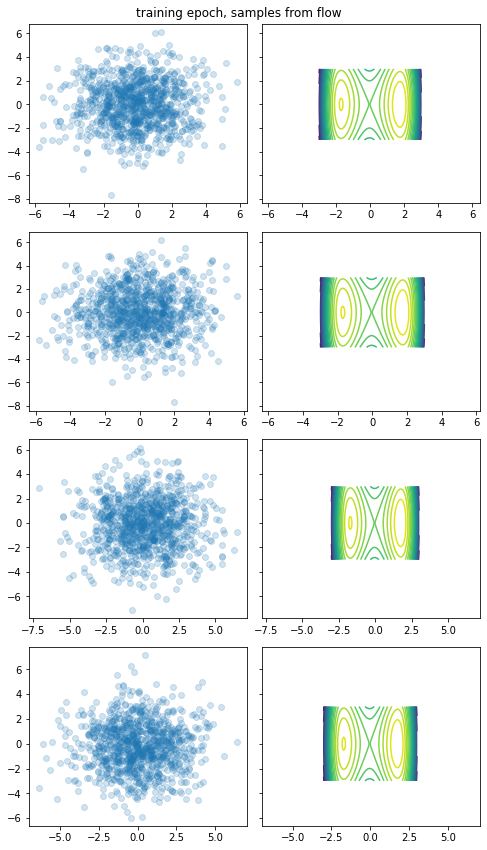

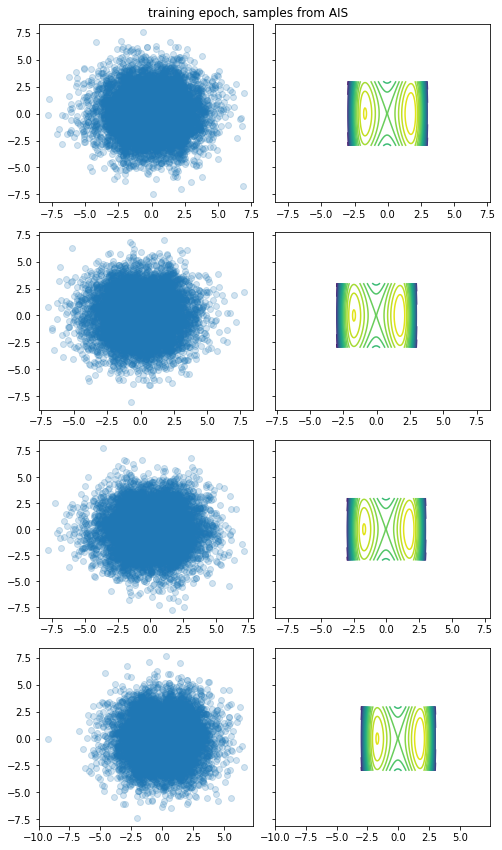

In [11]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|                                                                                                                                                          | 0/300 [00:00<?, ?it/s]

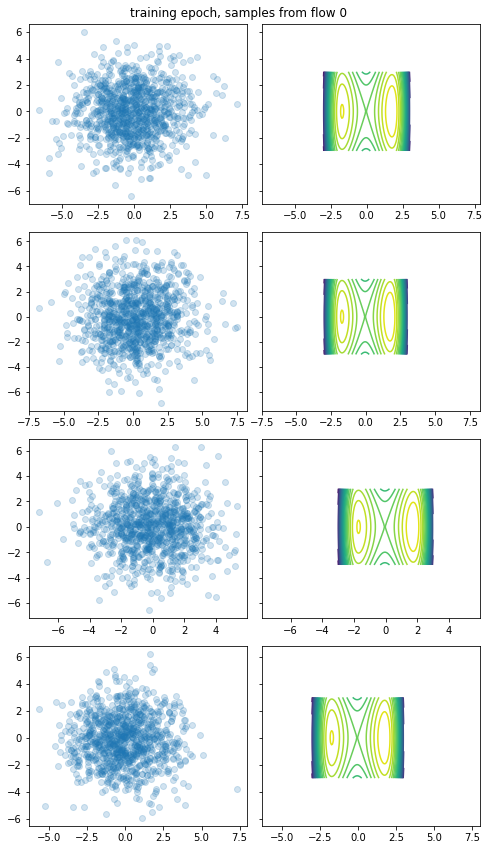

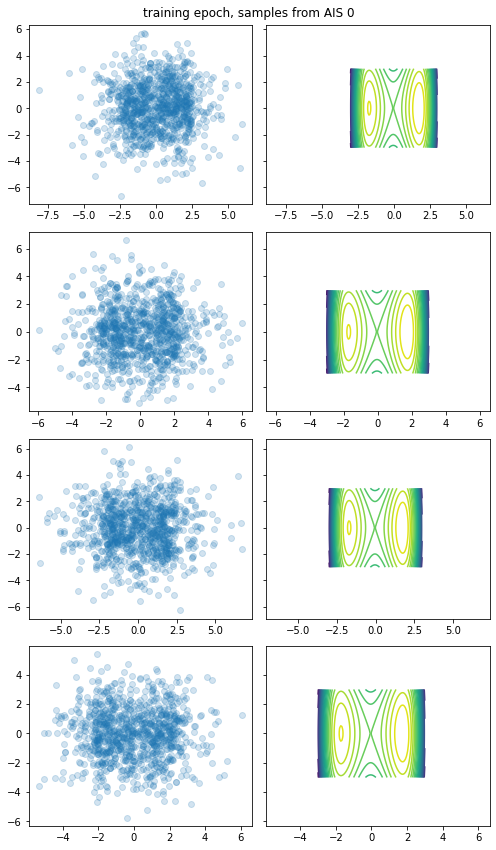

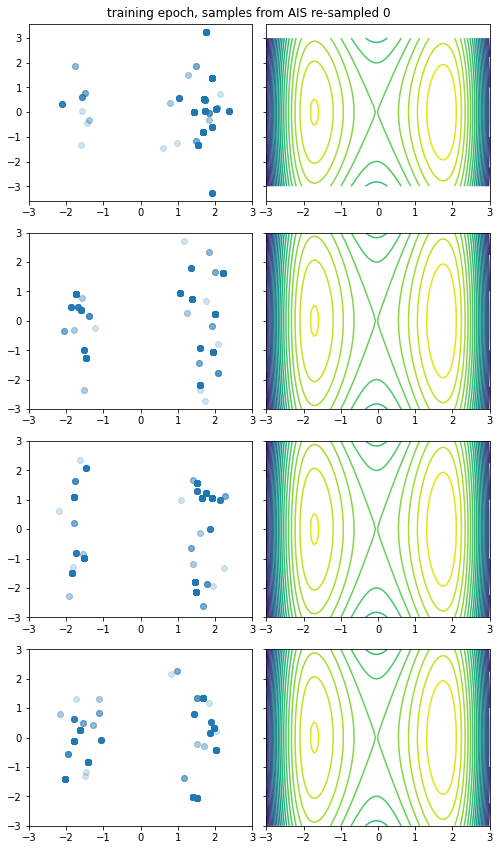

  1%|▉                                                                                                                                                 | 2/300 [00:17<47:34,  9.58s/it]

found a NaN and overwrote it during flow gradient calculation: None


loss: 68.69329499346544,   log_p_x_post_AIS 17.998753193917178, ESS 0.02218731127611509:  20%|███████████▏                                            | 60/300 [06:31<25:00,  6.25s/it]

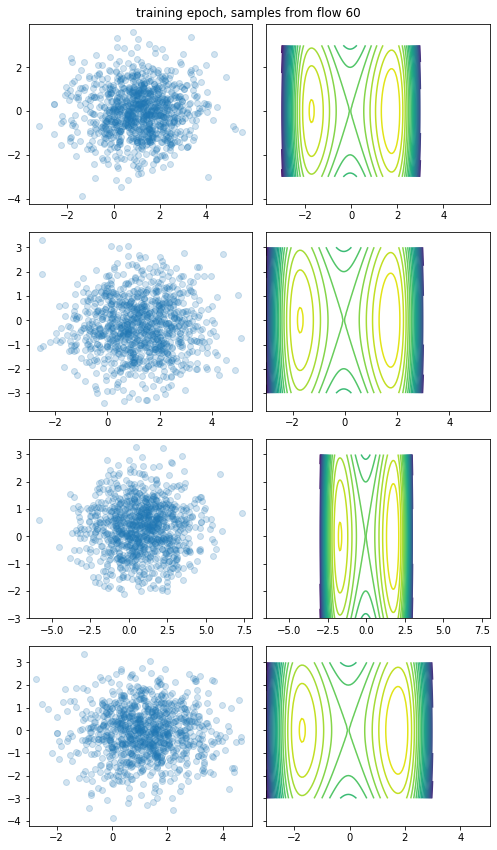

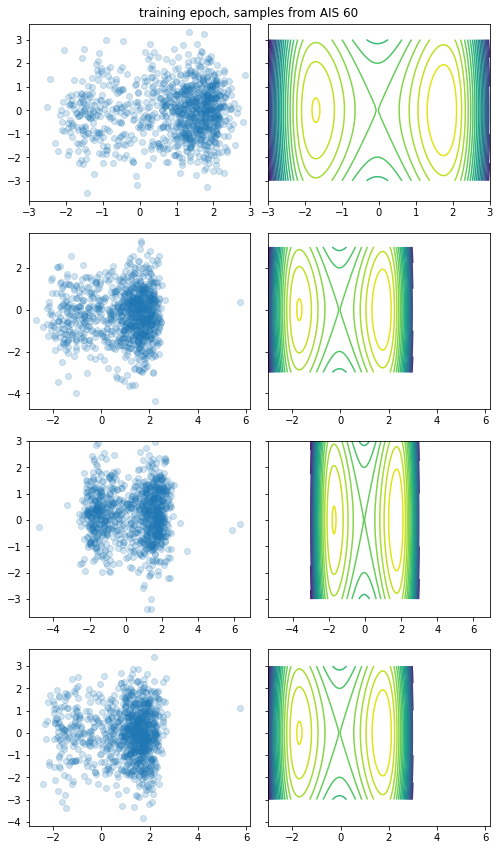

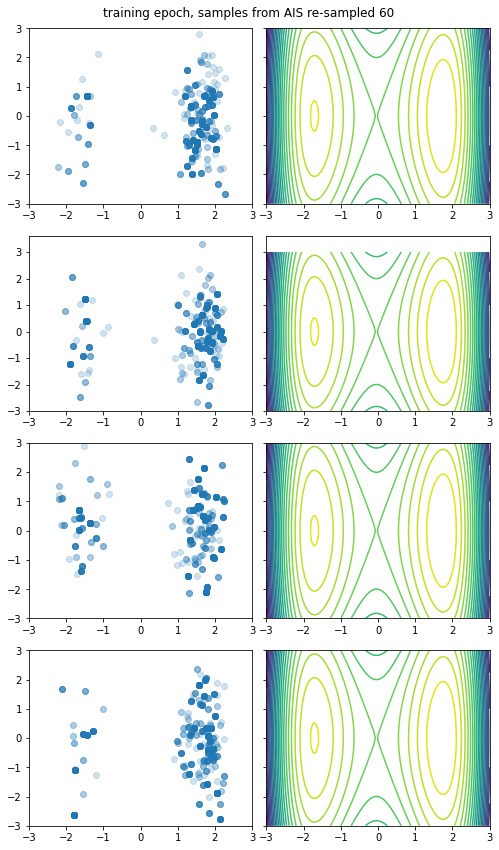

loss: 90.65196072755911,   log_p_x_post_AIS 13.749275979701478, ESS 0.013244135324094778:  40%|█████████████████████▌                                | 120/300 [13:01<18:47,  6.27s/it]

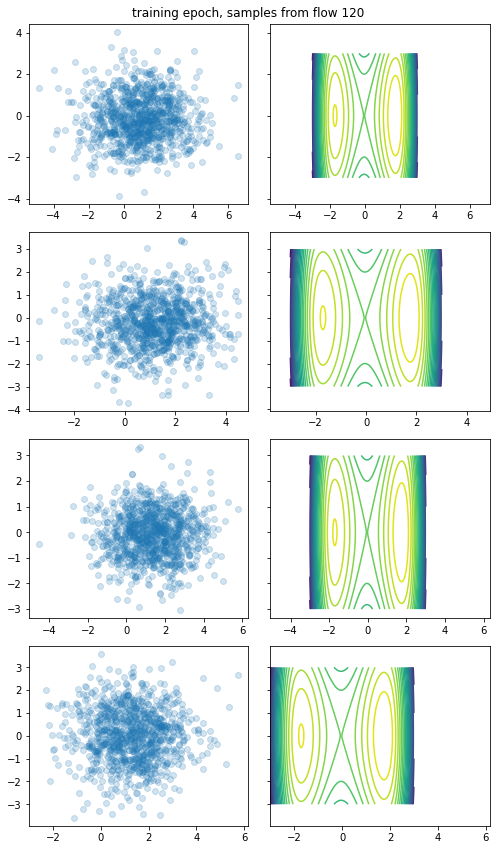

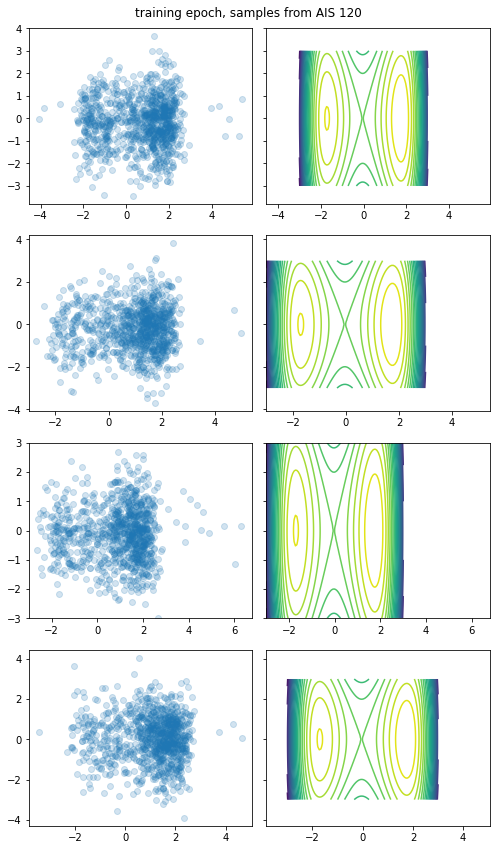

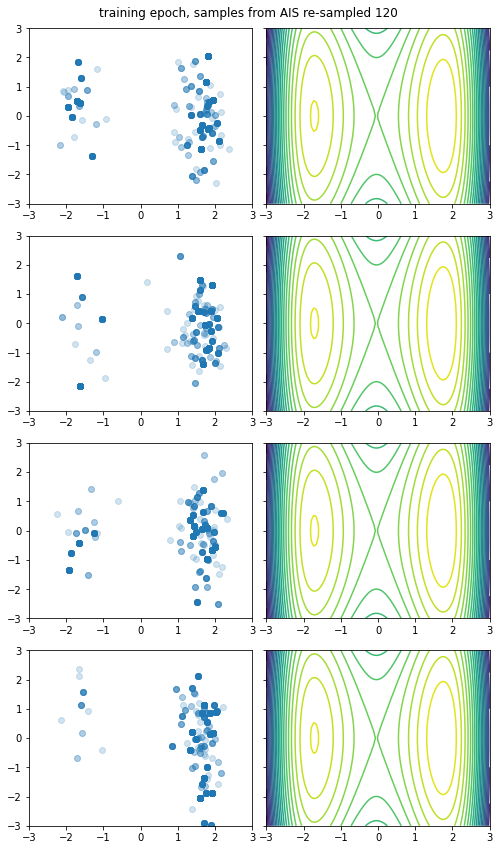

loss: 70.49376000042503,   log_p_x_post_AIS 10.50381461724672, ESS 0.017532893216310217:  60%|█████████████████████████████████                      | 180/300 [19:28<12:40,  6.34s/it]

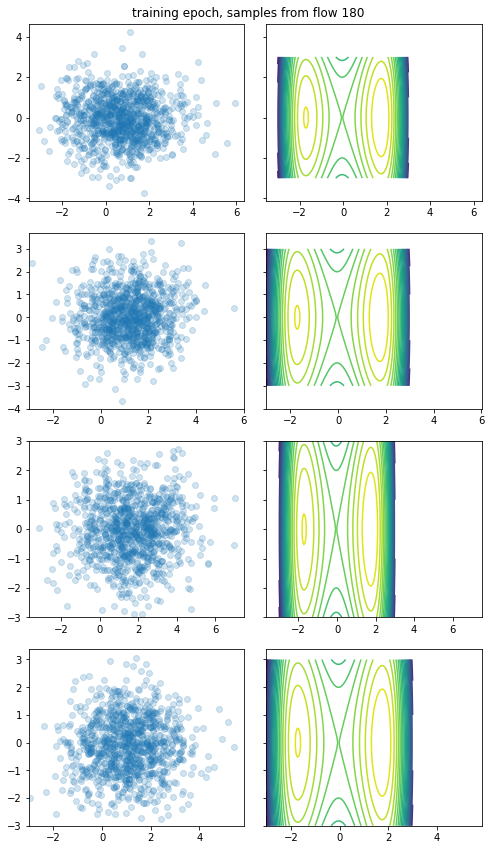

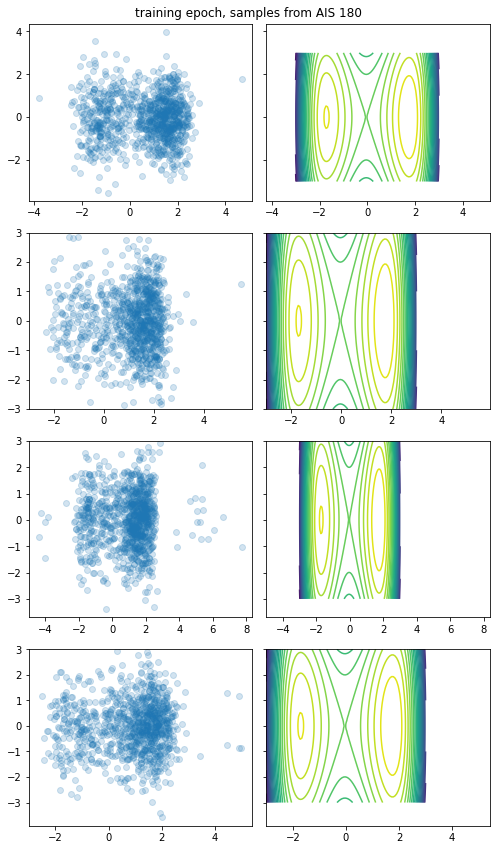

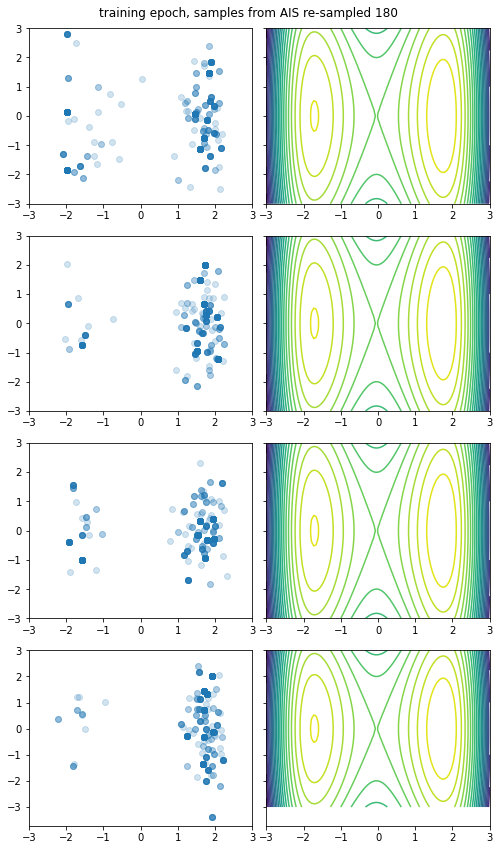

loss: 79.78488012021822,   log_p_x_post_AIS 18.501781626826073, ESS 0.012261621156397388:  80%|███████████████████████████████████████████▏          | 240/300 [25:56<06:21,  6.35s/it]

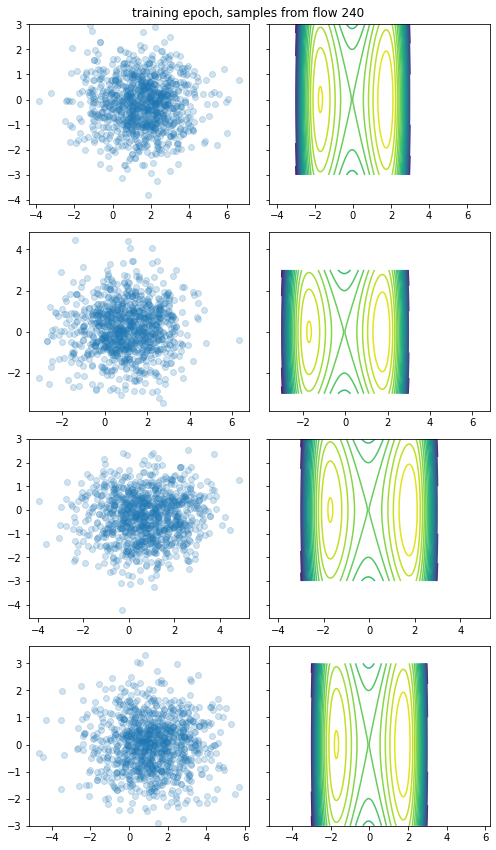

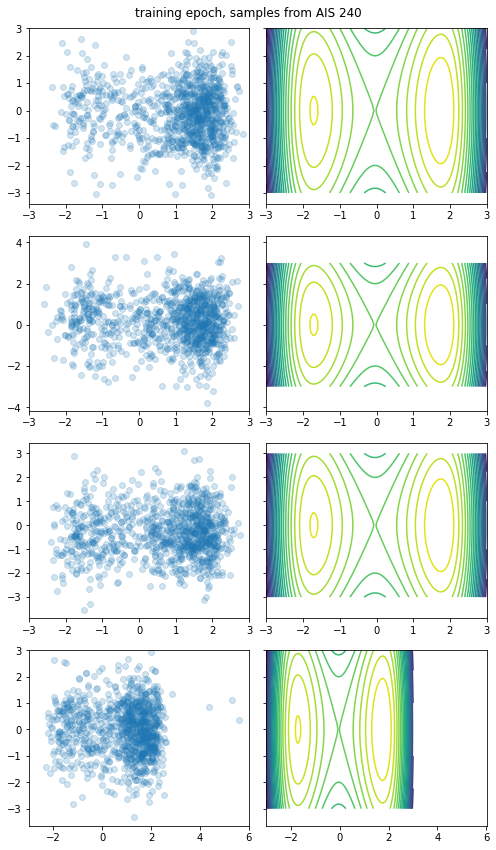

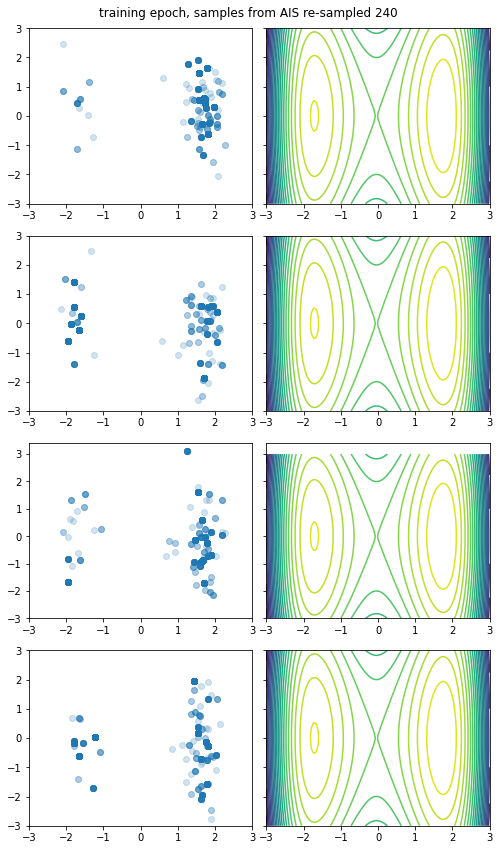

loss: 88.00033640790241,   log_p_x_post_AIS 22.022684161356466, ESS 0.013875227169976967: 100%|██████████████████████████████████████████████████████| 300/300 [32:13<00:00,  6.44s/it]


In [13]:
history = tester.train(300, batch_size=int(1e3), intermediate_plots=True, n_plots=5, plotting_func=plotter)

NaN encountered in log_w history
NaN encountered in first_p_accept history
NaN encountered in last_p_accept history


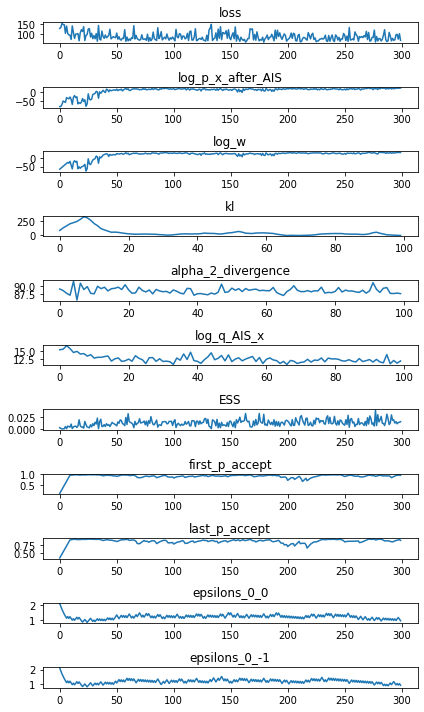

In [14]:
plot_history(history)

NaN encountered in log_w history


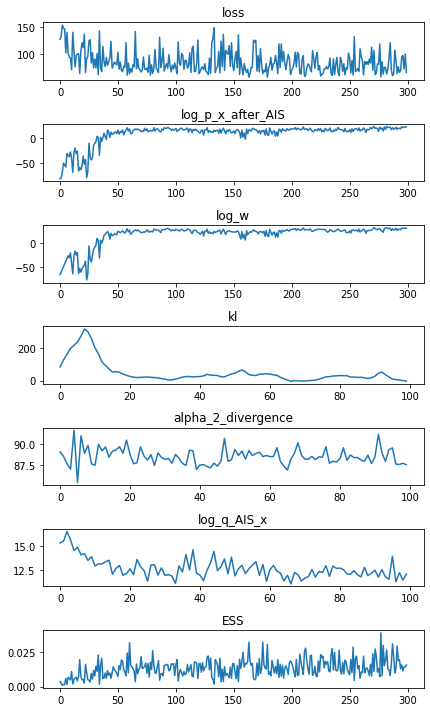

In [15]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

In [16]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.011013245006581922


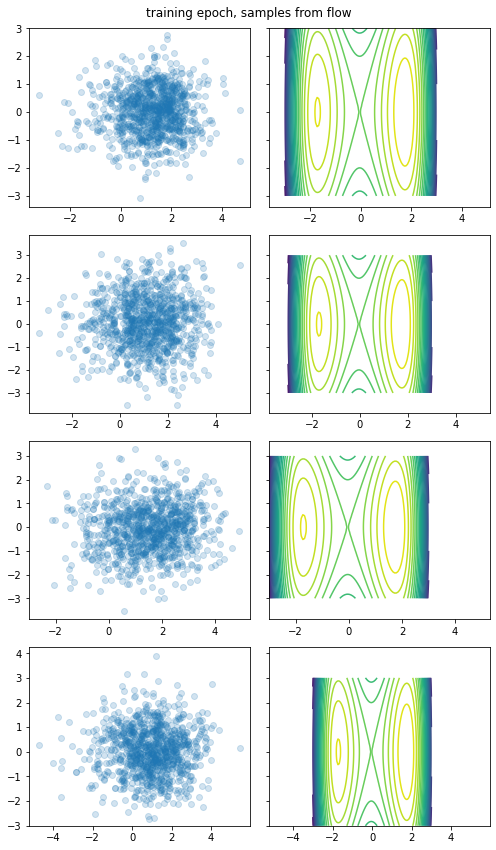

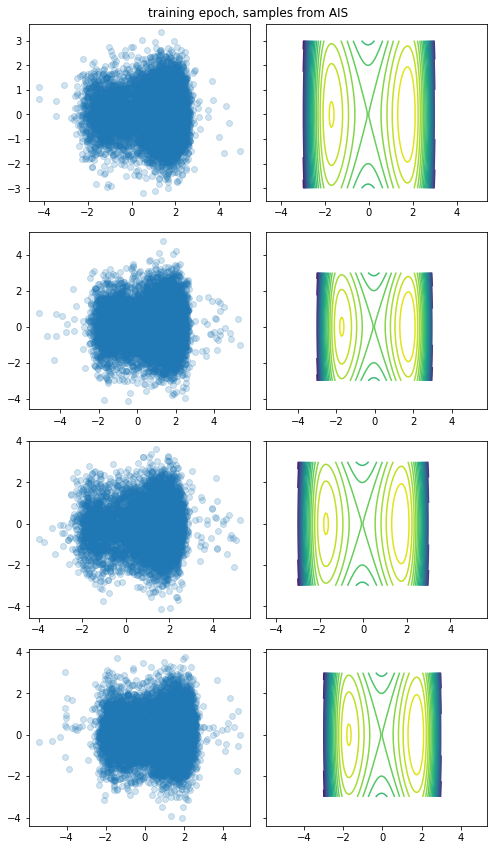

In [17]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])